In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt, dates
import datetime
from sklearn import linear_model
from scipy.spatial.distance import cosine

sb.set_context("poster")
plt.style.use('ggplot')
%matplotlib inline

In [4]:
def get_stock(stock_ticker):
    stock = yf.Ticker(stock_ticker)
    #periods = “1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
    stock_dic = {}
    stock_dic['ticker'] = stock_ticker
    stock_dic['1d'] = stock.history(period='1d', interval='1m', actions=False)
    stock_dic['5d'] = stock.history(period='5d', interval='1d', actions=False)
    stock_dic['1mo'] = stock.history(period='1mo', interval='1d', actions=False)
    stock_dic['6mo'] = stock.history(period='6mo', interval='1d', actions=False)
    
    return stock_dic

In [5]:
def get_linear_fit(df, period):
    df_copy = df.copy()
    if period == '1d':
        df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).seconds
    else:
        df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).days
    x = df_copy.loc[:, 'period_from_start'].T
    y = df_copy.loc[:, 'Close']
    polyfit_close = np.polyfit(x, y, 1)
    function = np.poly1d(polyfit_close) 
    df_copy['linear_fit'] = function(df_copy.loc[:, 'period_from_start'])
    return df_copy

In [18]:
def get_values(df):
    values_dic = {}
    values_dic['min_val'] = round(df.loc[:, 'Close'].min(), 2)
    values_dic['min_idx'] = df.loc[:, 'Close'].idxmin()
    values_dic['max_val'] = round(df.loc[:, 'Close'].max(), 2)
    values_dic['max_idx'] = df.loc[:, 'Close'].idxmax()
    values_dic['mean_val'] = round(df.loc[:, 'Close'].mean(), 2)
    values_dic['last_val'] = round(df.loc[:, 'Close'].iloc[-1], 2)
    values_dic['last_idx'] = df.iloc[-1]
    values_dic['last_linear'] = round(df.loc[:, 'linear_fit'].iloc[-1], 2)
    
    index_diff = (df.index[1] - df.index[0]).total_seconds()
    slope_diff = df.loc[:, 'linear_fit'].iloc[1] - df.loc[:, 'linear_fit'].iloc[0]
    #values_dic['linear_diff_by_sec'] = slope_diff / index_diff
    
    if slope_diff > 0:
        sign = '+'
    elif slope_diff < 0:
        sign = '-'
    values_dic['linear_sign'] = sign
    
    df_copy = df.copy()
    df_copy['mean_for_cosine'] = values_dic['mean_val']
    values_dic['cosine_similarity'] = round((1 - cosine(df['linear_fit'], df_copy['mean_for_cosine'])), 4)
    
    return values_dic

In [21]:
def analysis(stock_dic):
    #putting values into a dataframe
    to_df = {}
    for i, key in enumerate(stock_dic.keys()):
        if i > 0:
            to_df[key] = get_values(stock_dic[key])
    val_df = pd.DataFrame.from_dict(to_df, orient='index')
    #print(val_df.columns)
    
    if round(val_df.loc['1mo', 'last_val']) == round(val_df.loc['1mo', 'max_val']):
        print('At 1 month max')
    
    #info about max and min
    print(f"Current price: {val_df.loc['5d', 'last_val']}")
    for key in stock_dic.keys():
        if key in ('5d', '1mo', '6mo'):
            print(f"Max {key}: {val_df.loc[key, 'max_val']} Min {key}: {val_df.loc[key, 'min_val']} Distance from mean: {round((val_df.loc[key, 'last_val'] - val_df.loc[key, 'mean_val']), 2)} Cosine similarity: {val_df.loc[key, 'linear_sign']}{val_df.loc[key, 'cosine_similarity']}")
            
            print(val_df.loc[key, 'max_val'])
            print(val_df.loc[key, 'max_val'] - (val_df.loc[key, 'max_val'] * 0.05))
            
            if round(val_df.loc[key, 'last_val']) == round(val_df.loc[key, 'max_val']):
                print(f'At {key} max')
            elif val_df.loc[key, 'last_val'] > (val_df.loc[key, 'max_val'] - (val_df.loc[key, 'max_val'] * 0.05)):
                print(f'Near {key} max')
            elif round(val_df.loc[key, 'last_val']) == round(val_df.loc[key, 'min_val']):
                print(f'At {key} min')
            elif val_df.loc[key, 'last_val'] > (val_df.loc[key, 'min_val'] + (val_df.loc[key, 'min_val'] * 0.05)):
                print(f'Near {key} min')
    
    #when to buy
    if val_df.loc['1mo', 'last_val'] < val_df.loc['1mo', 'mean_val']: #and val_df.loc['1mo', 'linear_diff_by_sec'] < 0:
        print('buy')
    
    #when to sell
    if val_df.loc['1mo', 'last_val'] > val_df.loc['1mo', 'last_linear']:
        print('sell')

In [22]:
stock_dic = get_stock('nflx')

In [23]:
for i, key in enumerate(stock_dic.keys()):
    if i > 0:
        stock_dic[key] = get_linear_fit(stock_dic[key], key)

In [24]:
analysis(stock_dic)

Current price: 657.58
Max 5d: 657.58 Min 5d: 645.72 Distance from mean: 6.05 Cosine similarity: +1.0
657.58
624.701
At 5d max
Max 1mo: 690.31 Min 1mo: 624.94 Distance from mean: 2.04 Cosine similarity: +0.9999
690.31
655.7945
Near 1mo max
Max 6mo: 690.31 Min 6mo: 484.98 Distance from mean: 97.94 Cosine similarity: +0.9952
690.31
655.7945
Near 6mo max


In [25]:
#if 6mo trend above median and not (near?) max, good buy
#if all trend above median and not (near?) max, good buy
#if 5d or 1mo trend above median but last close below, great buy
#if close above median and trend (by how much?), great sell
#percentages above average
#try to fit a sin wave to graph - count frequency of rises and dips

#when price is close to max/min, depends on if current price is above or below mean?
#how to get percentages?

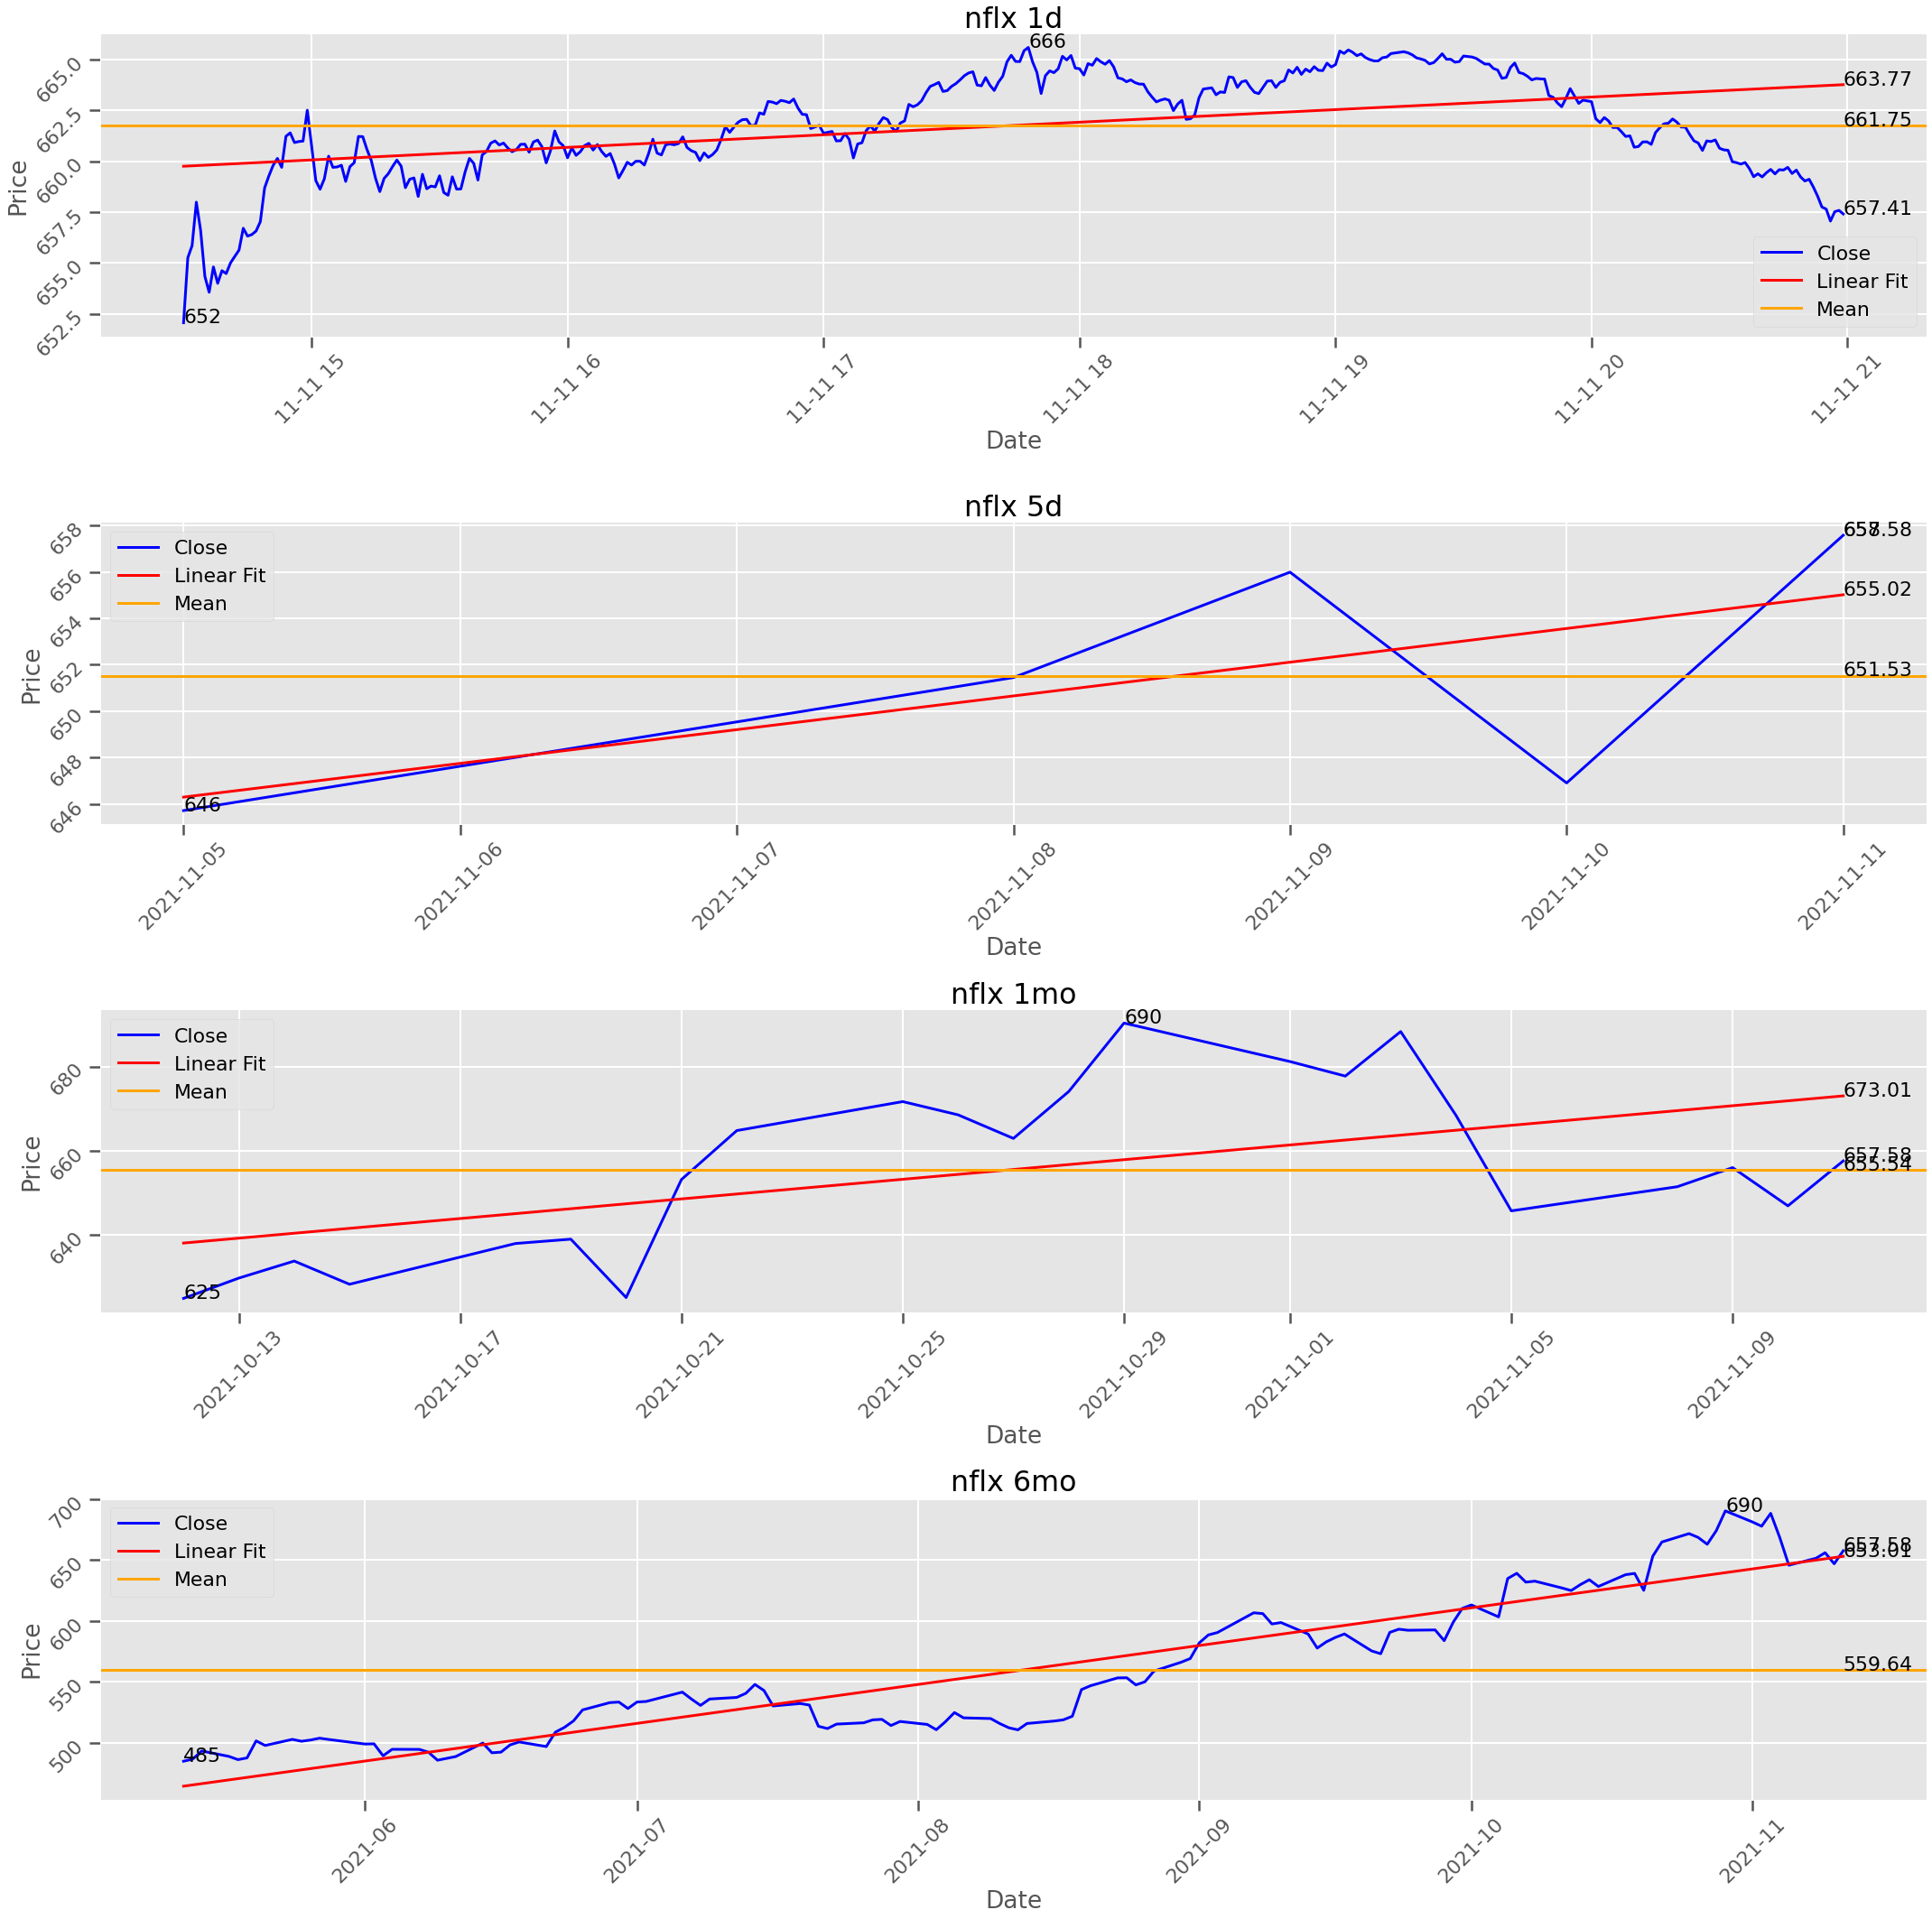

In [26]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(4, figsize=(30, 30))

for j, key in enumerate(stock_dic.keys()):
    if j > 0:
        i = j - 1
        ax[i].set_title(f'{stock_dic["ticker"]} {key}')
        ax[i].plot(stock_dic[key].loc[:, 'Close'], color='b', label='Close')
        ax[i].plot(stock_dic[key].loc[:, 'linear_fit'], color='r', label='Linear Fit')
        ax[i].axhline(stock_dic[key].loc[:, 'Close'].mean(), color='orange', label='Mean')
        
        ax[i].annotate(round(stock_dic[key].loc[:, 'Close'].max()), (stock_dic[key].loc[:, 'Close'].idxmax(), stock_dic[key].loc[:, 'Close'].max()))
        ax[i].annotate(round(stock_dic[key].loc[:, 'Close'].min()), (stock_dic[key].loc[:, 'Close'].idxmin(), stock_dic[key].loc[:, 'Close'].min()))
        
        ax[i].annotate(round(stock_dic[key].loc[:, 'Close'].iloc[-1], 2), (stock_dic[key].index[-1], stock_dic[key].loc[:, 'Close'].iloc[-1]))
        ax[i].annotate(round(stock_dic[key].loc[:, 'linear_fit'].iloc[-1], 2), (stock_dic[key].index[-1], stock_dic[key].loc[:, 'linear_fit'].iloc[-1]))
        ax[i].annotate(round(stock_dic[key].loc[:, 'Close'].mean(), 2), (stock_dic[key].index[-1], stock_dic[key].loc[:, 'Close'].mean()))

        ax[i].legend()

        ax[i].set_xlabel('Date')
        ax[i].set_ylabel('Price')
        ax[i].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()